# Configuración

In [1]:
import json
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Prerequisitos

Este notebook se debe ejecutar desde el directorio en el que se encuentra la carpeta `nutrition5k_sample`. Si se ejecuta en Colab, se debe subir la carpeta desde la sección archivos.

# Análisis del dataset

El dataset [Nutrition5k](https://github.com/google-research-datasets/Nutrition5k) contiene aproximadamente 5.000 platos con ingredientes, proporciones de los ingredientes e información nutricional. Estos platos se prepararon en 2 cafetería distintas de California, pesando cada ingrediente y obteniendo la información nutricional de cada uno de ellos en la base de datos [FoodData Central](https://fdc.nal.usda.gov/) del Departamento de Agricultura de Estados Unidos. Además, se incluyen 4 vídeos de cada plato, cada uno tomado desde un ángulo diferente. Para este trabajo usaremos únicamente los platos preparados en la primera cafetería, puesto que los datos de la segunda contienen mucho ruido (en una buena parte de los vídeos no se ve el plato). Tambiés se han excluido todos los platos para los que no había vídeos o para los que la suma de sus nutrientes era mayor que su peso. Los datos de estos platos se encuentran en el archivo `nutrition5k_sample/dish_metadata_cafe1.json`:

In [2]:
with open('nutrition5k_sample/dish_metadata_cafe1.json', encoding='UTF-8') as f:
  dishes = json.load(f) 

Estos platos están divididos en 3 particiones: entrenamiento, validación y test. A continuación se muestra el número de platos en total y en cada una de las particiones:

In [3]:
stats = {
  'train': 0,
  'val': 0,
  'test': 0,
}

for dish in dishes.values():
  stats[dish['partition']] += 1

print(f'{len(dishes)} platos:')
print(f'\t{stats["train"]} platos para entrenamiento')
print(f'\t{stats["val"]} platos para validación')
print(f'\t{stats["test"]} platos para test\n')

4600 platos:
	3237 platos para entrenamiento
	689 platos para validación
	674 platos para test



Los nombres de los ingredientes se encuentran en el archivo `nutrition5k_sample/ingredients_metadata.json`. A continuación se muestra el tamaño del vocabulario de ingredientes y algunos ejemplos:

In [4]:
with open('nutrition5k_sample/ingredients_metadata.json', encoding='UTF-8') as f:
  ingredients = json.load(f)

print(f'{len(ingredients)} ingredientes distintos')
print('Ejemplos:')
for ingredient in list(ingredients.values())[:5]:
  print(f'\t"{ingredient}"')

555 ingredientes distintos
Ejemplos:
	"cottage cheese"
	"strawberries"
	"garden salad"
	"bacon"
	"potatoes"


En la lista de ingredientes aparecen algunos como "ensalada" o "pizza" que no son realmente ingredientes, más bien son platos completos. Por tanto, este dataset no es muy adecuado para entrenar un modelo que identifique ingredientes.

A continuación se muestran dos vídeos de un mismo plato del dataset visto desde diferentes ángulos:

<video src="nutrition5k_sample/sample_videos/dish_1562872432_camera_B.mp4" controls="true" width="400"></video>
<video src="nutrition5k_sample/sample_videos/dish_1562872432_camera_D.mp4" controls="true" width="400"></video>

(Si no aparecen los vídeos, se pueden ver en el repositorio)

Para entrenar los modelos se utilizarán imágenes obtenidas extrayendo cada quinto fotograma de un vídeo. Algunos ejemplos extraídos los vídeos mostrados anteriormente y de otros del dataset se muestran a continuación:

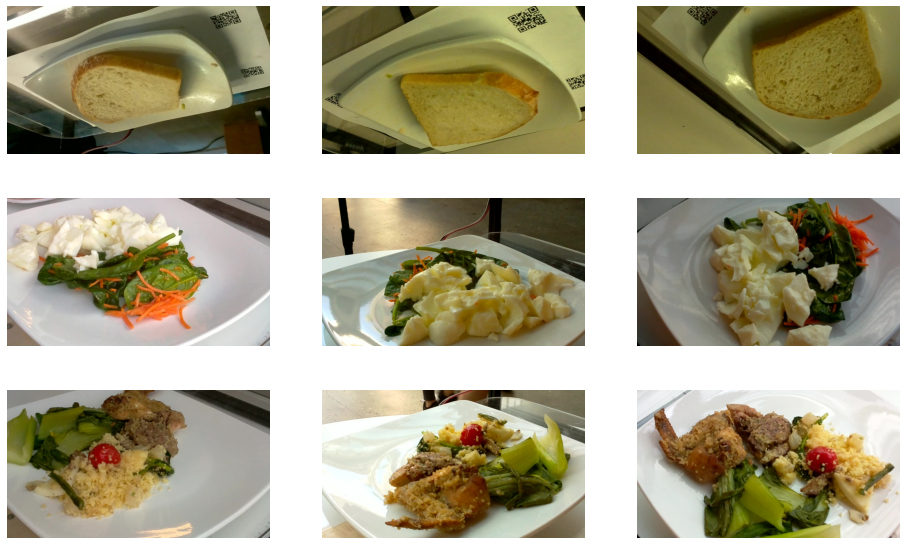

In [36]:
images = os.listdir('nutrition5k_sample/sample_images')

i = 1
plt.figure(figsize=(16, 10))
for image in images:
  plt.subplot(3, 3, i)
  plt.imshow(plt.imread(f'nutrition5k_sample/sample_images/{image}'))
  plt.axis("off")
  i += 1


Una buena parte de las imágenes (como las de la primera fila), están volteadas verticalmente. Esto se debe a que los vídeos de los que proceden también lo están. Sin embargo, esto no tiene por qué ser un problema, puesto que es deseable que los modelos entrenados sean invariantes a la rotación. A cointunación se muestra el número total de imágenes que se han extraído, así como su distribución entre las distintas particiones:

In [41]:
with open('nutrition5k_sample/images_per_dish.json', encoding='UTF-8') as f:
    images_per_dish = json.load(f)

total_imgages = 0
images_per_partition = {
    'train': 0,
    'val': 0,
    'test': 0
}

for id, dish in dishes.items():
    dish_images = images_per_dish[id]
    total_imgages += dish_images
    images_per_partition[dish['partition']] += dish_images

print(f'{total_imgages} imágenes:')
print(f'\t{images_per_partition["train"]} imágenes para entrenamiento')
print(f'\t{images_per_partition["val"]} imágenes para validación')
print(f'\t{images_per_partition["test"]} imágenes para test\n')

252934 imágenes:
	178436 imágenes para entrenamiento
	38152 imágenes para validación
	36346 imágenes para test



A continuación se muestra toda la información que nos interesa del plato de los vídeos, es decir, los ingredientes y sus proporciones por 100 g, su información nutricional por 100 g y algunas de sus imágenes:

Plato dish_1562872432

Ingredientes por 100 g:
	3.37 g de wheat berry
	27.63 g de couscous
	0.08 g de basil
	0.17 g de lemon juice
	1.69 g de zucchini
	1.69 g de squash
	0.67 g de olive oil
	0.84 g de spinach (raw)
	0.02 g de pepper
	33.72 g de chicken
	29.57 g de bok choy
	0.17 g de parsley
	0.17 g de garlic
	0.04 g de salt
	0.08 g de rosemary
	0.08 g de thyme

Información nutricional por 100 g:
	Energía: 100.81 kcal
	Grasas: 2.04 g
	Hidratos de carbono: 7.90 g
	Proteínas: 12.17 g

Imágenes:


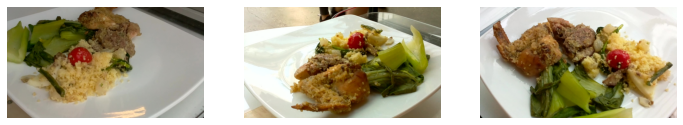

In [12]:
filename_regex = re.compile('(dish_[0-9]+)_camera_[A-D].mp4')
dish_id = filename_regex.match(os.listdir('nutrition5k_sample/sample_videos')[0]).group(1)
dish = dishes[dish_id]

nutr_vals = {
  'energy': {
    'translation': 'Energía',
    'units': 'kcal'
  }, 'fat': {
    'translation': 'Grasas',
    'units': 'g'
  }, 'protein': {
    'translation': 'Proteínas',
    'units': 'g'
  }, 'carbs': {
    'translation': 'Hidratos de carbono',
    'units': 'g'
  }
}

print(f'Plato {dish_id}')
print('\nIngredientes por 100 g:')
for ingr, weight in zip(dish['ingredients'], dish['weight_per_ingr']):
  print(f'\t{weight:.2f} g de {ingredients[ingr]}')

nutr_info = dish['nutr_values_per100g']
print('\nInformación nutricional por 100 g:')
for key, val in dish['nutr_values_per100g'].items():
  val_info = nutr_vals[key]
  print(f'\t{val_info["translation"]}: {val:.2f} {val_info["units"]}')

print('\nImágenes:')
i = 1
plt.figure(figsize=(12, 3))
for image in os.listdir('nutrition5k_sample/sample_images'):
  if re.findall(dish_id, image):
    plt.subplot(1, 3, i)
    plt.imshow(plt.imread(f'nutrition5k_sample/sample_images/{image}'))
    plt.axis("off")
    i += 1

A continuación, se muestran las distribuciones de ingredientes por plato y de imágenes por plato:

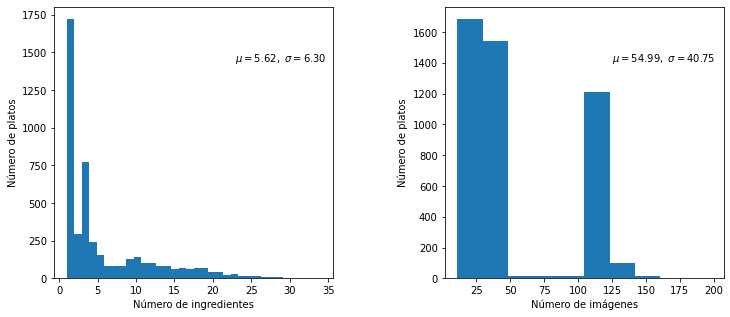

In [45]:
ingr_number_dist = list(map(lambda recipe: len(recipe['ingredients']), dishes.values()))
image_number_dist = [count for dish, count in images_per_dish.items() if dish in dishes]

def plot_mean_std(x, y, axis, dist):
  text = f'$\mu={np.mean(dist):.2f},\ \sigma={np.std(dist):.2f}$'
  axis.text(x, y, text, transform=axis.transAxes)

fig = plt.figure(figsize=(12, 5))

ax = plt.subplot(1, 2, 1)
plt.hist(ingr_number_dist, bins=max(ingr_number_dist))
plt.xlabel('Número de ingredientes')
plt.ylabel('Número de platos')
plot_mean_std(0.65, 0.8, ax, ingr_number_dist)

ax = plt.subplot(1, 2, 2)
plt.hist(image_number_dist)
plt.xlabel('Número de imágenes')
plt.ylabel('Número de platos')
plot_mean_std(0.6, 0.8, ax, image_number_dist)

plt.subplots_adjust(wspace=0.4)
plt.show()

También es interesante conocer los ingredientes más populares en el dataset. A continuación se muestra una gráfica con el número de apariciones de los 30 ingredientes más frecuentes:

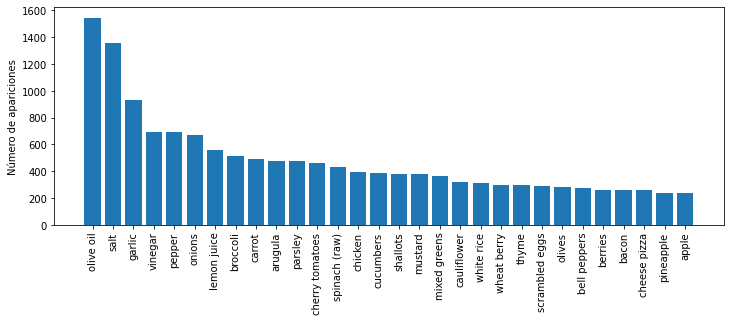

In [37]:
ingredient_ids = list(ingredients.keys())
ingr_dist = defaultdict(lambda: 0)
for dish in dishes.values():
    for ingredient in dish['ingredients']:
        ingr_dist[ingredient] += 1
top_ingrs = sorted(ingr_dist.items(), key=lambda pair: pair[1], reverse=True)[:30]
top_ingr_ids, appearances = zip(*top_ingrs)

plt.figure(figsize=(12, 4))
plt.xticks(rotation='vertical')
plt.bar(list(map(lambda ingr_id: ingredients[ingr_id], top_ingr_ids)), appearances)
plt.ylabel('Número de apariciones')
plt.show()

Para finalizar, vamos a mostrar la distribución de cada valor nutricional:

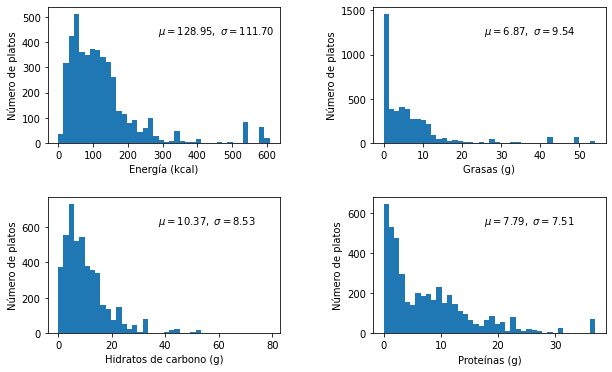

In [38]:
nutr_dist = defaultdict(lambda: [])

for dish in dishes.values():
  for key, value in dish['nutr_values_per100g'].items():
    nutr_dist[key].append(value)

plt.figure(figsize=(10, 6))

i = 1
for key, dist in nutr_dist.items():
  ax = plt.subplot(2, 2, i)
  plt.hist(dist, bins=40)
  plt.xlabel(f'{nutr_vals[key]["translation"]} ({nutr_vals[key]["units"]})')
  plt.ylabel('Número de platos')
  plot_mean_std(0.475, 0.8, ax, dist)
  i += 1

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()